# Exploration of PCA and Regression


---

Original notebook by Patrick Da Silva

### Motivation
> Multicollinearity can weaken the predictive power of features in **multiple linear regression (MLR)**. One way to fix this is to use a technique called **Principal Components Analysis (PCA)**. PCA is a method that helps simplify and reduce the number of variables through a process called "dimensionality reduction." The new variables (principal components) should allow predictions to become more accurate and efficient.

### Data and Objective
> There are six predictor features. Five measurements of fish size and one categorical variable containg the fish species.

> The goal of this project is to accurately predict the weight of a fish given these features.

### Applications and Context
> Fish weight estimation is important for fishermen and anglers, but manually calculating it can be time-consuming, error-prone, and harmful for the fish. This model can be employed in an app that allows users to input simpler fish measurements and receive accurate and efficient estimates of fish weight.

### Methods
> I compared the performance of five regression algorithms on a dataset with one-hot encoded categorical variables and scaled numerical variables.

> I tested four of the five algorithms with the additional step of applying PCA using different numbers of components. I evaluated the models using cross-validation with the R2 metric and graphed the results to compare their efficacy.

### Results
> I found the polynomial kernel to be the most effective at predicting the target variable (fish weight), even when using PCA to reduce the numerical data to a single dimension, with an R2 score of 0.9768.

### Discussion
> One method to improve results is to handle outliers. 

# 1. Load Data / Import Basics

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/Fish.csv')

# 2. Understand Relationships in Data

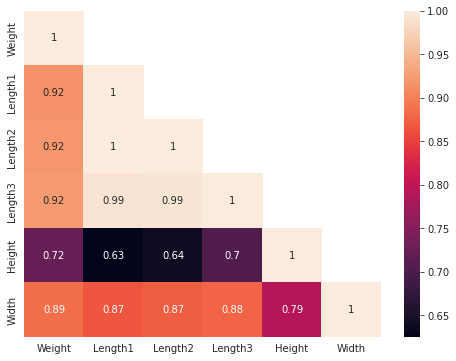

In [ ]:
fig = plt.figure(figsize=(8,6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, mask=np.triu(corr_matrix, k=1))
plt.show()

This heatmap clearly shows that many of the predictor features are very highly correlated with each other. This was the basis for performing PCA.

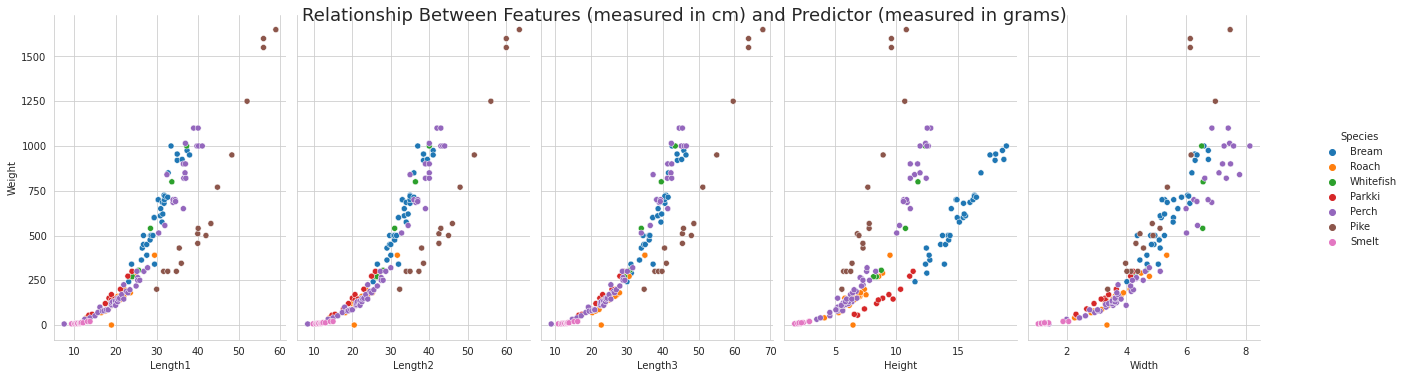

In [ ]:
fig1 = sns.pairplot(df, x_vars=['Length1','Length2','Length3','Height','Width'], y_vars=['Weight'], hue='Species')
fig1.fig.set_size_inches(20,6)
fig1.fig.suptitle('Relationship Between Features (measured in cm) and Predictor (measured in grams)', fontsize=18)
plt.show()

#### This plot shows:
- species will play a key role in understanding the relationship between the features and the target.
- the relationships between the features and target (weight) are non-linear

# 3. Establish Baseline Model Performance

### 3.1 Preprocess and cross-validate models

In [ ]:
def baseline_cross_val(X, y, models):
  """ 
    Parameters
      X: dataframe with features to predict
      y: the target feature
      models: a list of models
    Return
      a dataframe with 1 row with cross validation scores corresponding to a column with the name of the model
  """
  from sklearn.pipeline import Pipeline
  from sklearn.compose import ColumnTransformer
  from sklearn.preprocessing import OneHotEncoder, StandardScaler
  from sklearn.model_selection import cross_val_score, RepeatedKFold
  # Apply one hot encoding to categorical features
  # Apply scaling to numerical features
  num_cols = X.select_dtypes(include='number').columns.tolist()
  baseline_preprocessing = ColumnTransformer(
    [('OneHotEncoder', OneHotEncoder(), ['Species']),
     ('StandardScaler', StandardScaler(), num_cols)]
  )
  # cross validation method
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

  # list to hold scores for each model
  scores = []
  # get the cross validated scores for each model and append each to the score list
  for i, model in enumerate(models):
    # create a pipeline with each model and evaluate using cross_val_score
    pipeline_i = Pipeline(
      [('preprocess', baseline_preprocessing),
      ('model', model[1])]
    )
    score = cross_val_score(pipeline_i, X, y, cv=cv, scoring='r2').mean()
    scores.append([model[0], score])
  # unpack scores and store them in a dataframe
  di = {score[0]: score[1] for score in scores}
  scores_df = pd.DataFrame(di, index=[0])
  return scores_df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

# Create objects for each model type

models = [['linear_regression', LinearRegression()], 
          ['random_forests', RandomForestRegressor()],
          ['RBF_Kernel', KernelRidge(kernel='rbf')],
          ['Polynomial_Kernel', KernelRidge(kernel='poly')],
          ['KNN', KNeighborsRegressor()]]

# shuffle data since fish categories are grouped
fish_data = df.sample(frac=1, random_state=0)
fish_data.reset_index(inplace=True, drop=True)
y = fish_data.pop('Weight')

baseline_scores = baseline_cross_val(fish_data, y, models)

### 3.2 Visualize Results

In [ ]:
def plot_baseline(scores):
  import seaborn as sns
  import matplotlib.pyplot as plt

  sns.set_style('whitegrid')
  plt.figure(figsize=(10,6))
  plt.title('baseline model performance', fontsize=20)
  plt.ylabel('R2 Scores', fontsize=15)
  plt.xlabel('Models',fontsize=15)
  sns.lineplot(x=scores.columns, y=scores.iloc[0], color='#395E1A')
  for i, ind_scores in enumerate(scores.iloc[0]):
    plt.text(i, ind_scores, f'{ind_scores:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold', bbox=dict(boxstyle='round,pad=.3', facecolor='#b1df8a', alpha=0.6))
  plt.show()

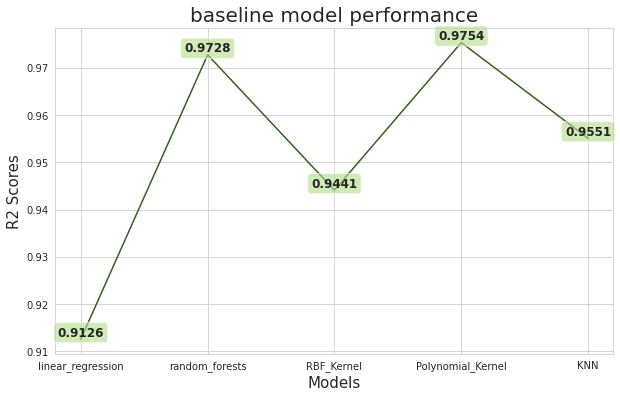

In [ ]:
plot_baseline(baseline_scores)

# 4. Applying Principal Component Analysis

### 4.1 Cross validate each model for each number of principal components

In [ ]:
def pca_cross_val(X, y, models):
  """
    Parameters
      X: dataframe with features to predict
      y: the target feature
      models: a list of models
    Return
      a dataframe where:
        rows are the number of principal components,
        columns correspond to a model
        values are the cross validated score for that model and PC
  """
  from sklearn.pipeline import Pipeline
  from sklearn.compose import ColumnTransformer
  from sklearn.preprocessing import OneHotEncoder, StandardScaler
  from sklearn.decomposition import PCA
  from sklearn.model_selection import cross_val_score, RepeatedKFold

  num_cols = X.select_dtypes(include='number').columns.tolist()
  
  # cross validation method
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
  # create a list to hold cross validation scores
  scores = []
  for model in models:
    # create a list to hold scores for prinicpal components of each model
    scores_j = []
    # loop 1-5 for each number of principal components
    for j in range(1,6):
      # Apply scaling and PCA of 'j' components to numerical features
      pca_preprocessing = ColumnTransformer(
        [('OneHotEncoder', OneHotEncoder(), ['Species']),
        ('StandardScaler', StandardScaler(), num_cols),
        ('PCA', PCA(n_components=j, random_state=0), num_cols)]
      )
      # create a pipeline to apply preprocessing and model to the data
      pca_pipe = Pipeline(
        [('preprocess', pca_preprocessing),
        ('model', model[1])]
      )
      # get cross validated score
      print('cross-validating:', model[0], 'with', j,  'PCs')
      score = cross_val_score(pca_pipe, X, y, cv=cv, scoring='r2').mean()
      # add the score to that model's list of scores
      scores_j.append(score)
    # add the entire model's scores to the master list
    scores.append([model[0], scores_j])
  # convert the scores list to a dataframe
  score_dict = {inner[0]: inner[1] for inner in scores}
  scores_df = pd.DataFrame(score_dict, index=np.arange(1,6))
  print('complete')
  return scores_df.round(decimals=4)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

# Create objects for each model type (dropped rbf kernel because of poor performance)
models = [['linear_regression', LinearRegression()], 
          ['random_forests', RandomForestRegressor()],
          ['Polynomial_Kernel', KernelRidge(kernel='poly')],
          ['KNN', KNeighborsRegressor()]]

# shuffle data because the fish categories are grouped
fish_data_pca = df.copy()
fish_data_pca.reset_index(inplace=True, drop=True)
y_pca = fish_data_pca.pop('Weight')

pca_scores = pca_cross_val(fish_data_pca, y_pca, models)

### 4.2 Vizualize PC Scores

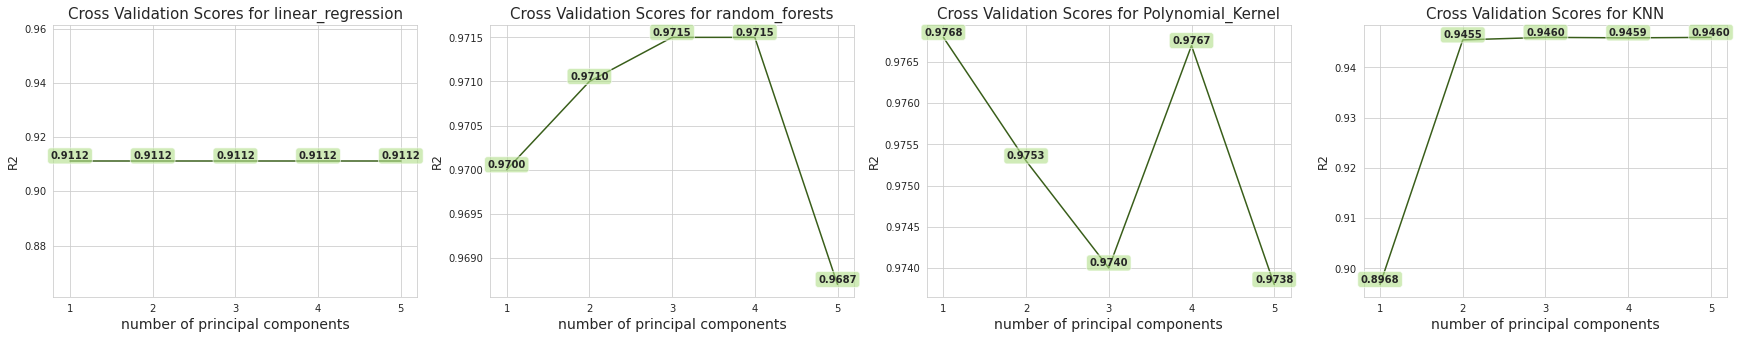

In [ ]:
# Create the figure with 5 subplots (axes) arranged in a 1x5 grid
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(30,5))

for i, model in enumerate(pca_scores):
  ax[i].plot(pca_scores[model], color='#395E1A')
  for j, score in enumerate(pca_scores[model]):
      ax[i].text(j+1, score, f"{score:.4f}", ha="center", va="bottom", fontsize=12, fontweight='bold', size='medium', bbox=dict(boxstyle='round,pad=.3', facecolor='#b1df8a', alpha=0.6))
  ax[i].set_title(f'Cross Validation Scores for {model}', fontsize=15)
  ax[i].set_xlabel('number of principal components', fontsize=14)
  ax[i].set_ylabel('R2', fontsize=12)
  ax[i].set_xticks([1,2,3,4,5])
  ax[i].grid(True)

plt.show()

# 5. Analysis and Final Pipeline

### 5.1 Analysis

The polynomial kernel was found to be the most effective at predicting the target variable, even when using PCA to reduce the numerical data to a single dimension, with an R2 score of 0.9768. <br>

The random forests regressor had a similar R2 score at 0.9719 at 3 principal components, but given its slower runtime it is not as effective as the polynomial kernel.

### 5.2 Proposed pipeline for predicting the weight of a fish:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

num_cols = fish_data.select_dtypes(include='number').columns.tolist()
preprocessing = ColumnTransformer(
        [('OneHotEncoder', OneHotEncoder(), ['Species']),
        ('StandardScaler', StandardScaler(), num_cols),
        ('PCA', PCA(n_components=1, random_state=0), num_cols)]
      )
pipeline = Pipeline(
        [('preprocess', preprocessing),
        ('model', KernelRidge(kernel='poly'))]
      )